### [Predicted Tracking Error(PTE) Rebalance Portfolio](https://pmorissette.github.io/bt/examples.html#:~:text=from%20both%20assets.-,Predicted%20Tracking%20Error%20Rebalance%20Portfolio,-import%20numpy%20as)

- 추적 오차 (Tracking Error): 포트폴리오의 수익률이 벤치마크 수익률과 얼마나 일치하는지를 나타내는 척도,  일반적으로 추적 오차가 작을수록 포트폴리오가 벤치마크를 잘 따라가고 있음을 의미
- 예측된 추적 오차 (Predicted Tracking Error): 앞으로의 추적 오차를 예측하는 값, 통계적 모델이나 과거 데이터를 기반으로 미래의 변동성을 예측한다.
- 예측된 추적 오차가 1%를 초과할 때마다 리밸런스를 수행함으로써 포트폴리오가 벤치마크를 벗어나는 것을 방지하고자 한다. 특히 인덱스 펀드나 벤치마크에 근접한 성과를 목표로 하는 전략에 유용하다.

In [2]:
import warnings
import matplotlib.pyplot as plt
import bt
import numpy as np
import pandas as pd

warnings.simplefilter(action="ignore")

%matplotlib inline

<Axes: >

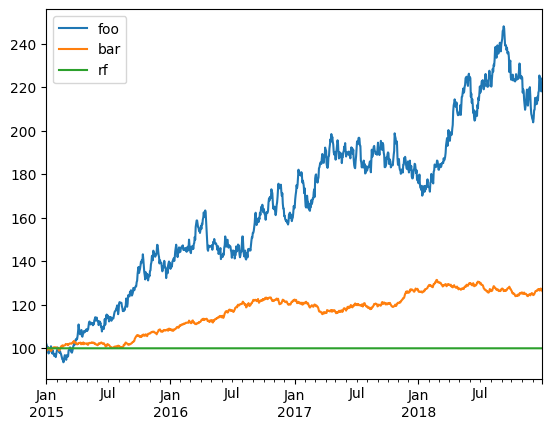

In [3]:
from pandas.tseries.offsets import BDay

names = ["foo", "bar", "rf"]
dates = pd.date_range(start="2015-01-01", end="2018-12-31", freq=BDay())
n = len(dates)
rdf = pd.DataFrame(np.zeros((n, len(names))), index=dates, columns=names)

np.random.seed(1)
rdf["foo"] = np.random.normal(loc=0.1 / 252, scale=0.2 / np.sqrt(252), size=n)
rdf["bar"] = np.random.normal(loc=0.04 / 252, scale=0.05 / np.sqrt(252), size=n)
rdf["rf"] = 0.0

pdf = 100 * np.cumprod(1 + rdf)
pdf.plot()

먼저 타겟이 될(추종될) 전략을 생성하고 백테스트를 돌린다.

In [4]:
from bt.core import Strategy
from bt.algos import SelectThese, WeighInvVol, Rebalance
from bt.backtest import Backtest

strategy = Strategy(
    "Target",
    algos=[
        SelectThese(["foo", "bar"]),
        WeighInvVol(
            lookback=pd.DateOffset(months=3), lag=pd.DateOffset(days=1)
        ),  # 3개월 전부터 어제까지의 데이터의 가격 변동성 기반, 변동성이 낮을수록 더 높은 가중치를 부여
        Rebalance(),
    ],
)

backtest = Backtest(strategy, pdf, integer_positions=False)
target_result = bt.run(backtest)

<Axes: >

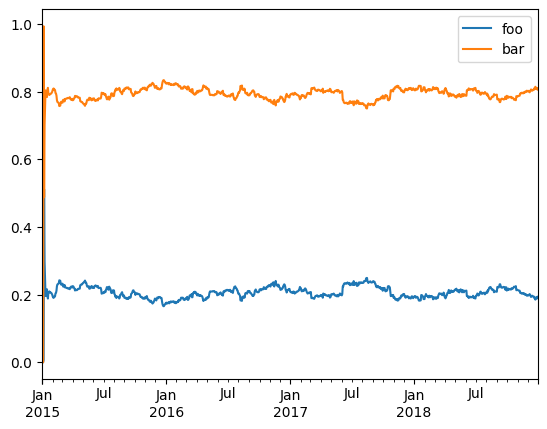

In [5]:
# 이 가중치를 PTE로 추정할 것이다.
target_result.get_security_weights().plot()

예측된 추적 오차가 1%를 초과하면 리밸런스를 수행한다.

In [6]:
from bt.algos import PTE_Rebalance, WeighTarget
from bt.backtest import Result

weight_df: pd.DataFrame = target_result.get_security_weights()
strategy = Strategy(
    "PTE",
    [
        PTE_Rebalance(
            PTE_volatility_cap=0.01, # 예측된 추적 오차가 1%를 초과하면 리밸런스
            target_weights=weight_df, # 초기 Target 전략에서 계산된 가중치를 목표로 한다.
            lookback=pd.DateOffset(months=3),
            lag=pd.DateOffset(days=1),
            covar_method="standard",  # 변동성 계산 방식
            annualization_factor=252, # 연간 변동성을 계산할 때 사용하는 연간화 계수(일반적으로 거래일 수를 사용)
        ),
        SelectThese(["foo", "bar"]),
        WeighTarget(weight_df),
        Rebalance()
    ],
)
backtest = Backtest(strategy, pdf, integer_positions=False)
pte_result:Result = bt.run(backtest)

[]

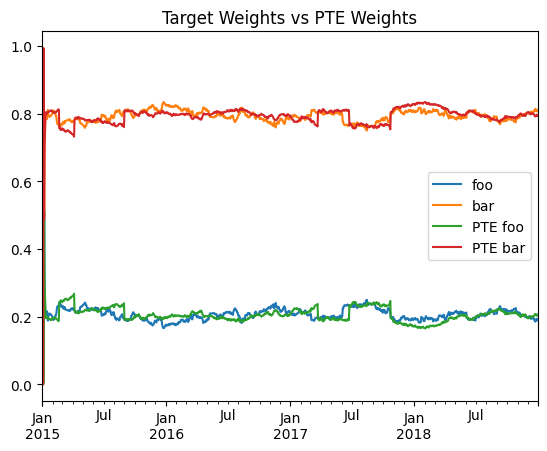

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
target_result.get_security_weights().plot(ax=ax)

realized_weights_df = pte_result.get_security_weights()
realized_weights_df['PTE foo'] = realized_weights_df['foo']
realized_weights_df['PTE bar'] = realized_weights_df['bar']
realized_weights_df = realized_weights_df.loc[:,['PTE foo', 'PTE bar']]
realized_weights_df.plot(ax=ax)

ax.set_title('Target Weights vs PTE Weights')
ax.plot()

In [8]:
trans_df = pd.DataFrame(
    index = target_result.prices.index,
    columns=["Target", "PTE"]
)

In [9]:
transactions = target_result.get_transactions()
transactions = (transactions["quantity"] * transactions["price"]).reset_index()
transactions

,Date,Security,0
0,2015-01-06,bar,993565.428052
1,2015-01-06,foo,6434.571948
2,2015-01-07,bar,-507420.868586
3,2015-01-07,foo,507420.868586
4,2015-01-08,bar,203564.474178
...,...,...,...
2075,2018-12-27,foo,3166.035915
2076,2018-12-28,bar,4794.203602
2077,2018-12-28,foo,-4794.203602
2078,2018-12-31,bar,-4209.258209


In [10]:
bar_mask = transactions.loc[:, "Security"] == "bar"
foo_mask = transactions.loc[:, "Security"] == "foo"

In [11]:
trans_df.loc[trans_df.index[4:], "Target"] = np.abs(transactions[bar_mask].iloc[:, 2].values) + np.abs(transactions[foo_mask].iloc[:, 2].values)
trans_df


,Target,PTE
2014-12-31,NaN,NaN
2015-01-01,NaN,NaN
2015-01-02,NaN,NaN
2015-01-05,NaN,NaN
2015-01-06,1000000.0,NaN
...,...,...
2018-12-25,9725.529158,NaN
2018-12-26,13776.894785,NaN
2018-12-27,6332.07183,NaN
2018-12-28,9588.407205,NaN


In [12]:
transactions = pte_result.get_transactions()
transactions

price      quantity
Date       Security                          
2015-01-06 bar        99.309091  10004.778160
           foo        99.384330     64.744331
2015-01-07 bar        99.692444  -5089.862875
           foo       100.507366   5048.593814
2015-01-08 bar       100.208933   2031.400484
           foo        97.632872  -2084.999341
2015-01-09 bar        99.942212    551.426220
           foo        99.817836   -552.113312
2015-01-12 bar        99.633593    507.056010
           foo        98.900163   -510.816267
2015-02-20 bar       101.041032   -561.214766
           foo        93.577955    605.973055
2015-04-07 bar       102.318016    553.613385
           foo       110.938796   -510.593456
2015-09-01 bar       101.807969    509.067816
           foo       124.004313   -417.946436
2017-03-23 bar       115.674872    519.662202
           foo       189.254819   -317.623927
2017-06-23 bar       119.521332   -534.925628
           foo       186.689382    342.467381
2017-10-24 bar       120.057436    543.745362
           foo       197.328487   -330.822350

In [13]:
transactions = (transactions["quantity"] * transactions["price"]).reset_index()
transactions

,Date,Security,0
0,2015-01-06,bar,993565.428052
1,2015-01-06,foo,6434.571948
2,2015-01-07,bar,-507420.868586
3,2015-01-07,foo,507420.868586
4,2015-01-08,bar,203564.474178
5,2015-01-08,foo,-203564.474178
6,2015-01-09,bar,55110.756085
7,2015-01-09,foo,-55110.756085
8,2015-01-12,bar,50519.811933
9,2015-01-12,foo,-50519.811933


In [15]:
bar_mask = transactions.loc[:,'Security'] == 'bar'
foo_mask = transactions.loc[:,'Security'] == 'foo'

trans_df.loc[transactions[bar_mask].iloc[:,0],'PTE'] =  np.abs(transactions[bar_mask].iloc[:,2].values)
trans_df.loc[transactions[foo_mask].iloc[:,0],'PTE'] +=  np.abs(transactions[foo_mask].iloc[:,2].values)

In [16]:
trans_df = trans_df.fillna(0)


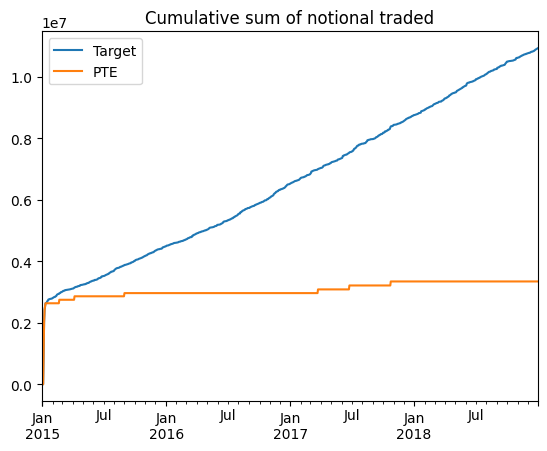

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=1)
trans_df.cumsum().plot(ax=ax)
ax.set_title('Cumulative sum of notional traded') # 거래된 금액의 누적 합계
ax.plot();

두 전략 모두 두 자산으로부터 유사한 양의 변동성 기여도를 보인다

[]

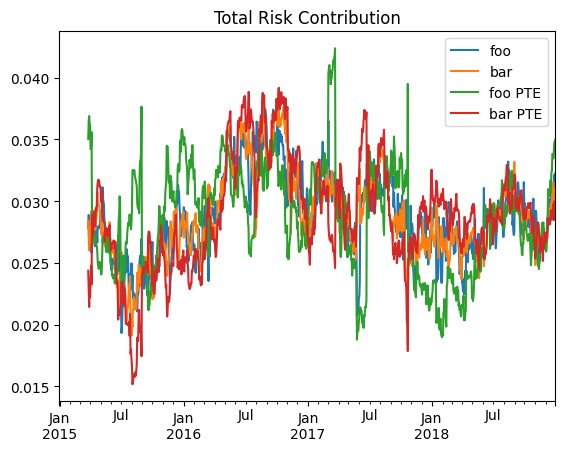

In [18]:
weights_target: pd.DataFrame = target_result.get_security_weights()
rolling_cov_target = (
    pdf.loc[:, weights_target.columns].pct_change().rolling(window=3 * 20).cov() * 252
)

weights_PTE: pd.DataFrame = pte_result.get_security_weights().loc[
    :, weights_target.columns
]
rolling_cov_PTE = (
    pdf.loc[:, weights_target.columns].pct_change().rolling(window=3 * 20).cov() * 252
)


trc_target = pd.DataFrame(
    np.nan, index=weights_target.index, columns=weights_target.columns
)

trc_PTE = pd.DataFrame(
    np.nan, index=weights_PTE.index, columns=[x + " PTE" for x in weights_PTE.columns]
)

for dt in pdf.index:
    trc_target.loc[dt, :] = (
        weights_target.loc[dt, :].values
        * (rolling_cov_target.loc[dt, :].values @ weights_target.loc[dt, :].values)
        / np.sqrt(
            weights_target.loc[dt, :].values
            @ rolling_cov_target.loc[dt, :].values
            @ weights_target.loc[dt, :].values
        )
    )
    trc_PTE.loc[dt, :] = (
        weights_PTE.loc[dt, :].values
        * (rolling_cov_PTE.loc[dt, :].values @ weights_PTE.loc[dt, :].values)
        / np.sqrt(
            weights_PTE.loc[dt, :].values
            @ rolling_cov_PTE.loc[dt, :].values
            @ weights_PTE.loc[dt, :].values
        )
    )


fig, ax = plt.subplots(nrows=1, ncols=1)
trc_target.plot(ax=ax)
trc_PTE.plot(ax=ax)
ax.set_title("Total Risk Contribution") # 각 자산이 전체 포트폴리오의 리스크(변동성)에 얼마나 기여하는지
ax.plot()

the Target strategy’s and PTE strategy’s Total Risk they are very similar

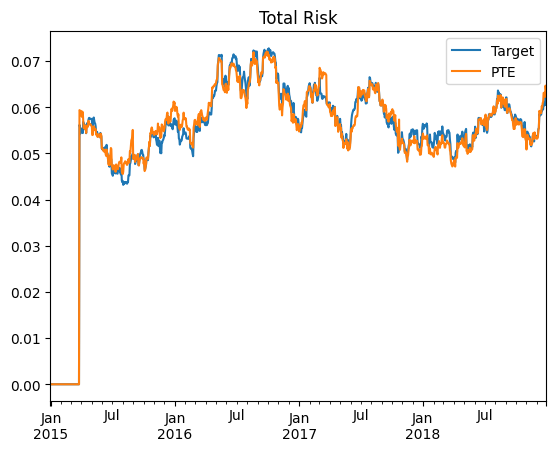

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=1)
trc_target.sum(axis=1).plot(ax=ax,label='Target')
trc_PTE.sum(axis=1).plot(ax=ax,label='PTE')
ax.legend()
ax.set_title('Total Risk')
ax.plot();

In [21]:
transactions = pte_result.get_transactions()
transactions = (transactions['quantity'] * transactions['price']).reset_index()

bar_mask = transactions.loc[:,'Security'] == 'bar'
dates_of_PTE_transactions = transactions[bar_mask].iloc[:,0]
dates_of_PTE_transactions

0    2015-01-06
2    2015-01-07
4    2015-01-08
6    2015-01-09
8    2015-01-12
10   2015-02-20
12   2015-04-07
14   2015-09-01
16   2017-03-23
18   2017-06-23
20   2017-10-24
Name: Date, dtype: datetime64[ns]

In [ ]:
np.sum(np.abs(trc_target.values - trc_PTE.values),axis=1)

We can see the Predicted Tracking Error of the PTE Strategy with each transaction marked.

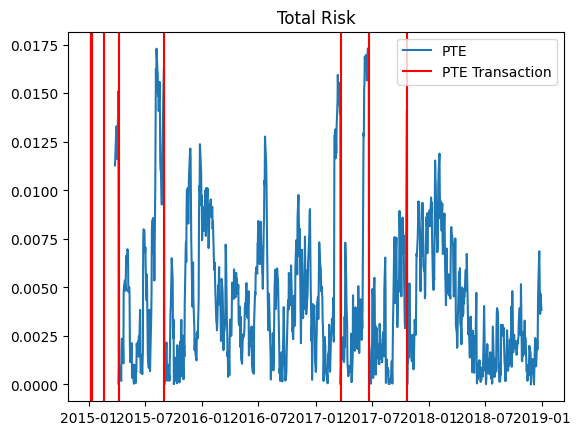

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_title('Total Risk')
ax.plot(
    trc_target.index,
    np.sum(np.abs(trc_target.values - trc_PTE.values),axis=1),
    label='PTE'
)

# 거래 발생한 지점에 수직선 긋기
for i,dt in enumerate(dates_of_PTE_transactions):
    if i == 0:
        ax.axvline(x=dt,color='red',label='PTE Transaction')
    else:
        ax.axvline(x=dt,color='red')

ax.legend();